# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8810, 9), (4340, 9), (8810,), (4340,))

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

* Function Definitios

Using the code created in the Notebook #13, will be define the same functions to create the Decision Tree Classifier Manually and, in that way, calculate the accuracy of the testing set.

In [5]:
# Gini calculator 

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [6]:
# Gini impurity calculator

def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [7]:
# Calculador for the best split given a dataset of feature and target

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [8]:
# Decision Tree calculador

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0) # Como guardo la informacion de cada nodo
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [9]:
# Decision Tree predictor (given the tree calculated)

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

* Calculation

In [10]:
DT_manual = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
DT_manual

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': -1,
    'n_samples': 98,
    'gain': -1},
   'sr': {'y_pred': 0,
    'y_prob': 0.46757679180887374,
    'level': 3,
    'split': -1,
    'n_samples': 291,
    'gain': -1}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8743054224947308,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 5217,
   'gain': 0.014933378976312917,
   'sl': {'y_pred': 1,
    'y_prob': 0.7348484848484849,
    'level': 3,
    'split': -1,
    'n_samples': 1450,
    'gain': -1},
   'sr': {'y_pred': 1,
    'y_prob': 0.92

In [11]:
y_pred_m = tree_predict(X_test, DT_manual)
y_pred_m

array([0., 1., 1., ..., 1., 1., 0.])

In [12]:
from sklearn import metrics

metrics.accuracy_score(y_test, y_pred_m)

0.8610599078341014

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [107]:
np.random.seed(666)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([6380, 7597, 2878, ..., 2275, 8185, 6233]),
 array([4981, 7384, 7525, ...,   32, 7060, 4579]),
 array([3409, 2624,  869, ..., 1651,  806, 3062]),
 array([6719, 2191, 5514, ..., 8319, 3650, 6088]),
 array([6151,  603, 5633, ..., 5484, 8405, 4278]),
 array([4696, 1811, 1278, ...,  170, 3245, 3705]),
 array([ 609, 7131, 8160, ..., 3382,  937, 2686]),
 array([1691, 1340, 2069, ..., 6295, 4421, 1086]),
 array([1296, 8426, 6267, ..., 3546, 5328, 6256]),
 array([3775, 5038, 4341, ..., 2572, 7504, 2675])]

In [108]:
X_train_bag = X_train.iloc[samples[0], :]
X_train_bag.head(5)

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
289675,2013,83040,0,0,0,0,0,0,1
396435,2009,126260,0,1,0,0,0,0,0
439891,2016,40217,0,0,0,0,0,1,0
49432,2012,77442,0,0,0,0,0,1,0
289675,2013,83040,0,0,0,0,0,0,1


In [116]:
# y_pred = pd.DataFrame(index=test.index, columns=[list(range(n_B))])
y_pred_tree = []

for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample, :]
    y_train = y_train.iloc[sample]
    tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred_tree.append(tree_predict(X_test, tree))

pd.DataFrame(y_pred_tree).head()    

,0,1,2,3,4,5,6,7,8,9,...,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339
0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [117]:
y_pred = (pd.DataFrame(y_pred_tree).sum() >= (n_B * 0.5 ) ).astype(np.int)

In [118]:
metrics.accuracy_score(y_test, y_pred)

0.8456221198156681

In [138]:
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


15         29242
47         26465
85         46739
141        41722
226        77669
244        18963
258        15063
333        46001
366        26609
452        87621
453        44173
466        83714
478        16186
514         7815
562        24754
691       155409
739        18500
767        29918
825        34791
874        50214
1033       21288
1055       97803
1074       35229
1102       92696
1176      134735
1200        1822
1231       48340
1259       27463
1347       18770
1377       32009
           ...  
498852    141346
498870    105485
498896     40469
498974     70217
498995     71879
499014     92398
499033     29931
499139     32315
499206        10
499265    118400
499320     28796
499338    166940
499371     76646
499416     32304
499422     49251
499442     39254
499461     80897
499478      2420
499496     13327
499554     30543
499560     48272
499577     54790
499629     52677
499729     33196
499754     18606
499785     46488
499889     10232
499937     346

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [217]:
def max_featur(X, tree, max_features):
    
    
    if max_features > X.shape[1]:
        return "ERROR: please correct the value 'max_features'"
    else:
        for i in range(max_features):
            aux = np.random.choice(a=np.arange(10), replace=True)
            Hola = X.iloc[:,aux]
            
        return Hola

In [231]:
max_featur(data, DT_manual, 6)

15        0
47        0
85        0
141       0
226       0
244       0
258       0
333       0
366       0
452       0
453       0
466       1
478       0
514       1
562       0
691       0
739       0
767       0
825       0
874       0
1033      0
1055      0
1074      0
1102      0
1176      0
1200      0
1231      0
1259      0
1347      0
1377      0
         ..
498852    0
498870    0
498896    0
498974    0
498995    0
499014    0
499033    0
499139    0
499206    0
499265    0
499320    0
499338    0
499371    0
499416    1
499422    0
499442    0
499461    0
499478    0
499496    0
499554    0
499560    0
499577    0
499629    0
499729    0
499754    0
499785    1
499889    0
499937    0
499971    1
499991    0
Name: M_CamryL, Length: 13150, dtype: uint8

4

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=None, random_state=666, n_jobs=-1)

C:\Users\AMartinez147\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [17]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=666, verbose=0, warm_start=False)

In [18]:
y_pred = clf.predict(X_test)

In [19]:
base = metrics.accuracy_score(y_test, y_pred)
base

0.8375576036866359

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [20]:
max_depth_p = []

for Max_depth in range(1, 50):
    clf = RandomForestClassifier(max_depth=Max_depth, random_state=666, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    max_depth_p.append(metrics.accuracy_score(y_test, y_pred))

max_depth_p_df = pd.DataFrame(max_depth_p)
max_depth_p_df.rename(columns={0 : 'max_depth'}, inplace=True)

Text(0,0.5,'Accuracy')

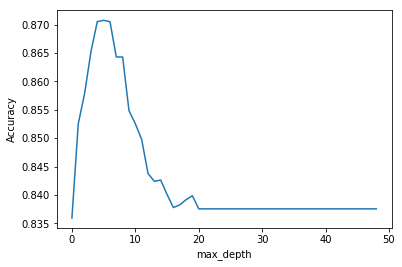

In [21]:
import matplotlib.pyplot as plt

plt.plot(max_depth_p_df)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [22]:
max_depth_p_df.loc[max_depth_p_df.max_depth == max_depth_p_df["max_depth"].max()]

,max_depth
5,0.870737


In [23]:
feature_cols = X.columns[X.columns.str.startswith('C') == False]
max_features_p = []

feature_range = range(1, len(feature_cols)+1)

for Max_features in feature_range:
    clf = RandomForestClassifier(max_features=Max_features, random_state=666, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    max_features_p.append(metrics.accuracy_score(y_test, y_pred))
    
max_features_p_df = pd.DataFrame(max_features_p)
max_features_p_df.rename(columns = {0 : 'max_features'}, inplace=True)

Text(0,0.5,'Accuracy')

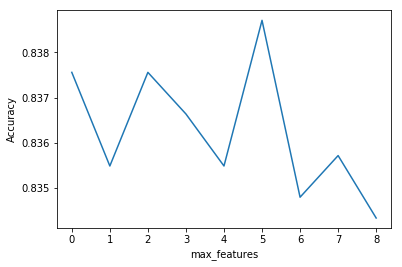

In [24]:
plt.plot(max_features_p_df)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [25]:
max_features_p_df.loc[max_features_p_df.max_features == max_features_p_df["max_features"].max()]

,max_features
5,0.83871


max_depth = 6

max_features = 8

In [26]:
estimator_range = range(1, 100, 1)
n_estimators_p = [base]

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=666, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    n_estimators_p.append(metrics.accuracy_score(y_test, y_pred))
    
n_estimators_p_df = pd.DataFrame(n_estimators_p)
n_estimators_p_df.rename(columns = {0 : 'n_estimators'}, inplace=True)

Text(0,0.5,'Accuracy')

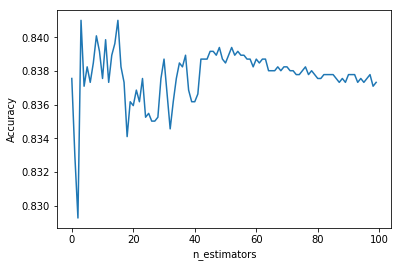

In [27]:
plt.plot(n_estimators_p_df)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [28]:
n_estimators_p_df.loc[n_estimators_p_df.n_estimators == n_estimators_p_df["n_estimators"].max()]

,n_estimators
3,0.841014
15,0.841014


Recopilando los resultados por separado, se obtiene que los mejores parametros son:


max_depth = 6 / max_features = 8 / n_estimators = 9

In [31]:
clf = RandomForestClassifier(max_depth=5, n_estimators=15, max_features=5, random_state=666, n_jobs=-1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.8730414746543779